In [1]:
from fastai.vision import *
from fastai.layers import *
import re
import cv2
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_csv_path = './train.csv'
train_data_path = './train_images'
test_csv_path = './test.csv'
test_data_path = './test_images'
unicode_csv_path = './unicode_translation.csv'

In [10]:
def _binarize(x):
    b = int(x.shape[1] * 2/3)
    b = b if b % 2 == 1 else b+1
    x = cv2.cvtColor(x.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2GRAY)
    x = (x*255).astype('uint8')
    x = cv2.adaptiveThreshold(x,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,b,2)
    x = torch.from_numpy(x/255).float()
    x = x.expand(3,x.shape[0], x.shape[1])
    return x
                           
binarize = TfmPixel(_binarize)

In [14]:
# Use for total data
db = ImageList.from_folder('./char_images') \
            .split_by_rand_pct() \
            .label_from_folder() \
            .transform([[binarize()], [binarize()]], size=(64,64)) \
            .databunch(bs=32)

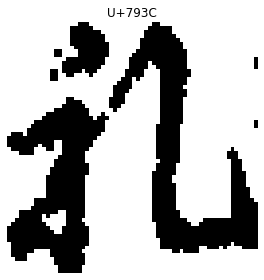

In [15]:
db.show_batch(rows=1)

In [16]:
learn = cnn_learner(db, models.resnet50, metrics=accuracy)
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 32, 32]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
MaxPool2d            [64, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [64, 16, 16]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 16, 16]         128        True      
______________________________________________________________________
Conv2d               [64, 16, 16]         36,864     False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


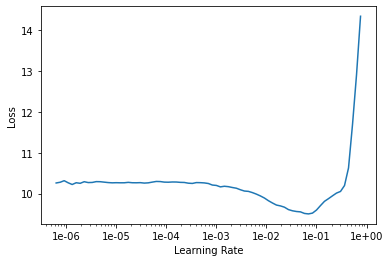

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.097503,1.636671,0.750418,55:01
1,1.681524,1.328292,0.803873,09:00
2,1.541248,1.169439,0.831641,08:59
3,1.427868,1.062179,0.853211,09:03
4,1.475067,1.087379,0.860603,08:57


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


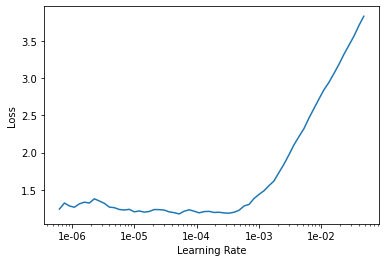

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.freeze()
learn.fit_one_cycle(10,slice(5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.491943,1.053609,0.848690,09:02
1,1.566344,1.177230,0.831223,08:53
2,1.496363,1.199025,0.828359,08:48
3,1.590356,1.170263,0.833846,08:49
4,1.483520,1.127926,0.838044,08:49
5,1.377895,1.093263,0.847701,08:50
6,1.309837,1.032158,0.856090,08:49
7,1.311840,0.986690,0.867725,08:51
8,1.155092,0.987695,0.872905,08:50
9,1.237599,1.032921,0.871725,08:49


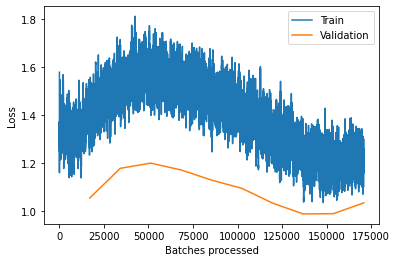

In [22]:
learn.recorder.plot_losses()